In [1]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import imageio
import cv2
from diff_gaussian_rasterization import GaussianRasterizer as Renderer
from utils.common_utils import seed_everything
from importlib.machinery import SourceFileLoader
from utils.recon_helpers import setup_camera
from PIL import Image

from datasets.gradslam_datasets import (
    load_dataset_config,
    ScannetPPDataset,
    ReplicaDataset,
)

from utils.eval_helpers import recolor_semantic_img, evaluate_miou

### Test ScanNet++ Semantic Maps

In [2]:
params = dict(np.load('./experiments/ScanNet++/8b5caf3398_0/params.npz', allow_pickle=True))
variables = {}
device = torch.device("cuda:0")

seed_everything(seed=0)

Seed set to: 0 (type: <class 'int'>)


In [9]:
def get_dataset(config_dict, basedir, sequence, **kwargs):
    return ScannetPPDataset(basedir, sequence, **kwargs)


file_path = './configs/scannetpp/slam.py'
experiment = SourceFileLoader(os.path.basename(file_path).replace('.py', ''), file_path).load_module()
config = experiment.config

print("Loading Dataset ...")
dataset_config = config["data"]
if "gradslam_data_cfg" not in dataset_config:
    gradslam_data_cfg = {}
    gradslam_data_cfg["dataset_name"] = dataset_config["dataset_name"]
else:
    gradslam_data_cfg = load_dataset_config(dataset_config["gradslam_data_cfg"])
if "ignore_bad" not in dataset_config:
    dataset_config["ignore_bad"] = False
if "use_train_split" not in dataset_config:
    dataset_config["use_train_split"] = True
if "load_semantics" not in dataset_config:
    load_semantics = False
    num_semantic_classes = 0
else:
    load_semantics = dataset_config["load_semantics"]
    num_semantic_classes = dataset_config["num_semantic_classes"]
    semantic_color_all_frames_map = []
    semantic_id_all_frames_map = []

dataset = get_dataset(
    config_dict=gradslam_data_cfg,
    basedir=dataset_config["basedir"],
    sequence=os.path.basename(dataset_config["sequence"]),
    start=dataset_config["start"],
    end=dataset_config["end"],
    stride=dataset_config["stride"],
    desired_height=dataset_config["desired_image_height"],
    desired_width=dataset_config["desired_image_width"],
    device=device,
    relative_pose=True,
    ignore_bad=dataset_config["ignore_bad"],
    use_train_split=dataset_config["use_train_split"],
    load_semantics=load_semantics,
    num_semantic_classes=num_semantic_classes,
)

Loading Dataset ...


In [10]:
for k in ['intrinsics', 'w2c', 'org_width', 'org_height', 'gt_w2c_all_frames', 'keyframe_time_indices']:
    # for k in ['timestep','intrinsics', 'w2c', 'org_width', 'org_height', 'gt_w2c_all_frames']:
    if k in params.keys():
        params.pop(k)

params_opt_exclude = {"semantic_ids"}

print(params.keys())
for k in params.keys():
    if k in params_opt_exclude:
        params[k] = torch.tensor(params[k]).cuda()
    else:
        params[k] = torch.tensor(params[k]).cuda().float().requires_grad_(True)

if 'semantic_ids' in params.keys():
    if params['semantic_ids'].dim() == 1:
        params['semantic_ids'] = params['semantic_ids'].unsqueeze(1)

dict_keys(['means3D', 'rgb_colors', 'unnorm_rotations', 'logit_opacities', 'log_scales', 'semantic_ids', 'semantic_colors', 'cam_unnorm_rots', 'cam_trans', 'timestep'])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


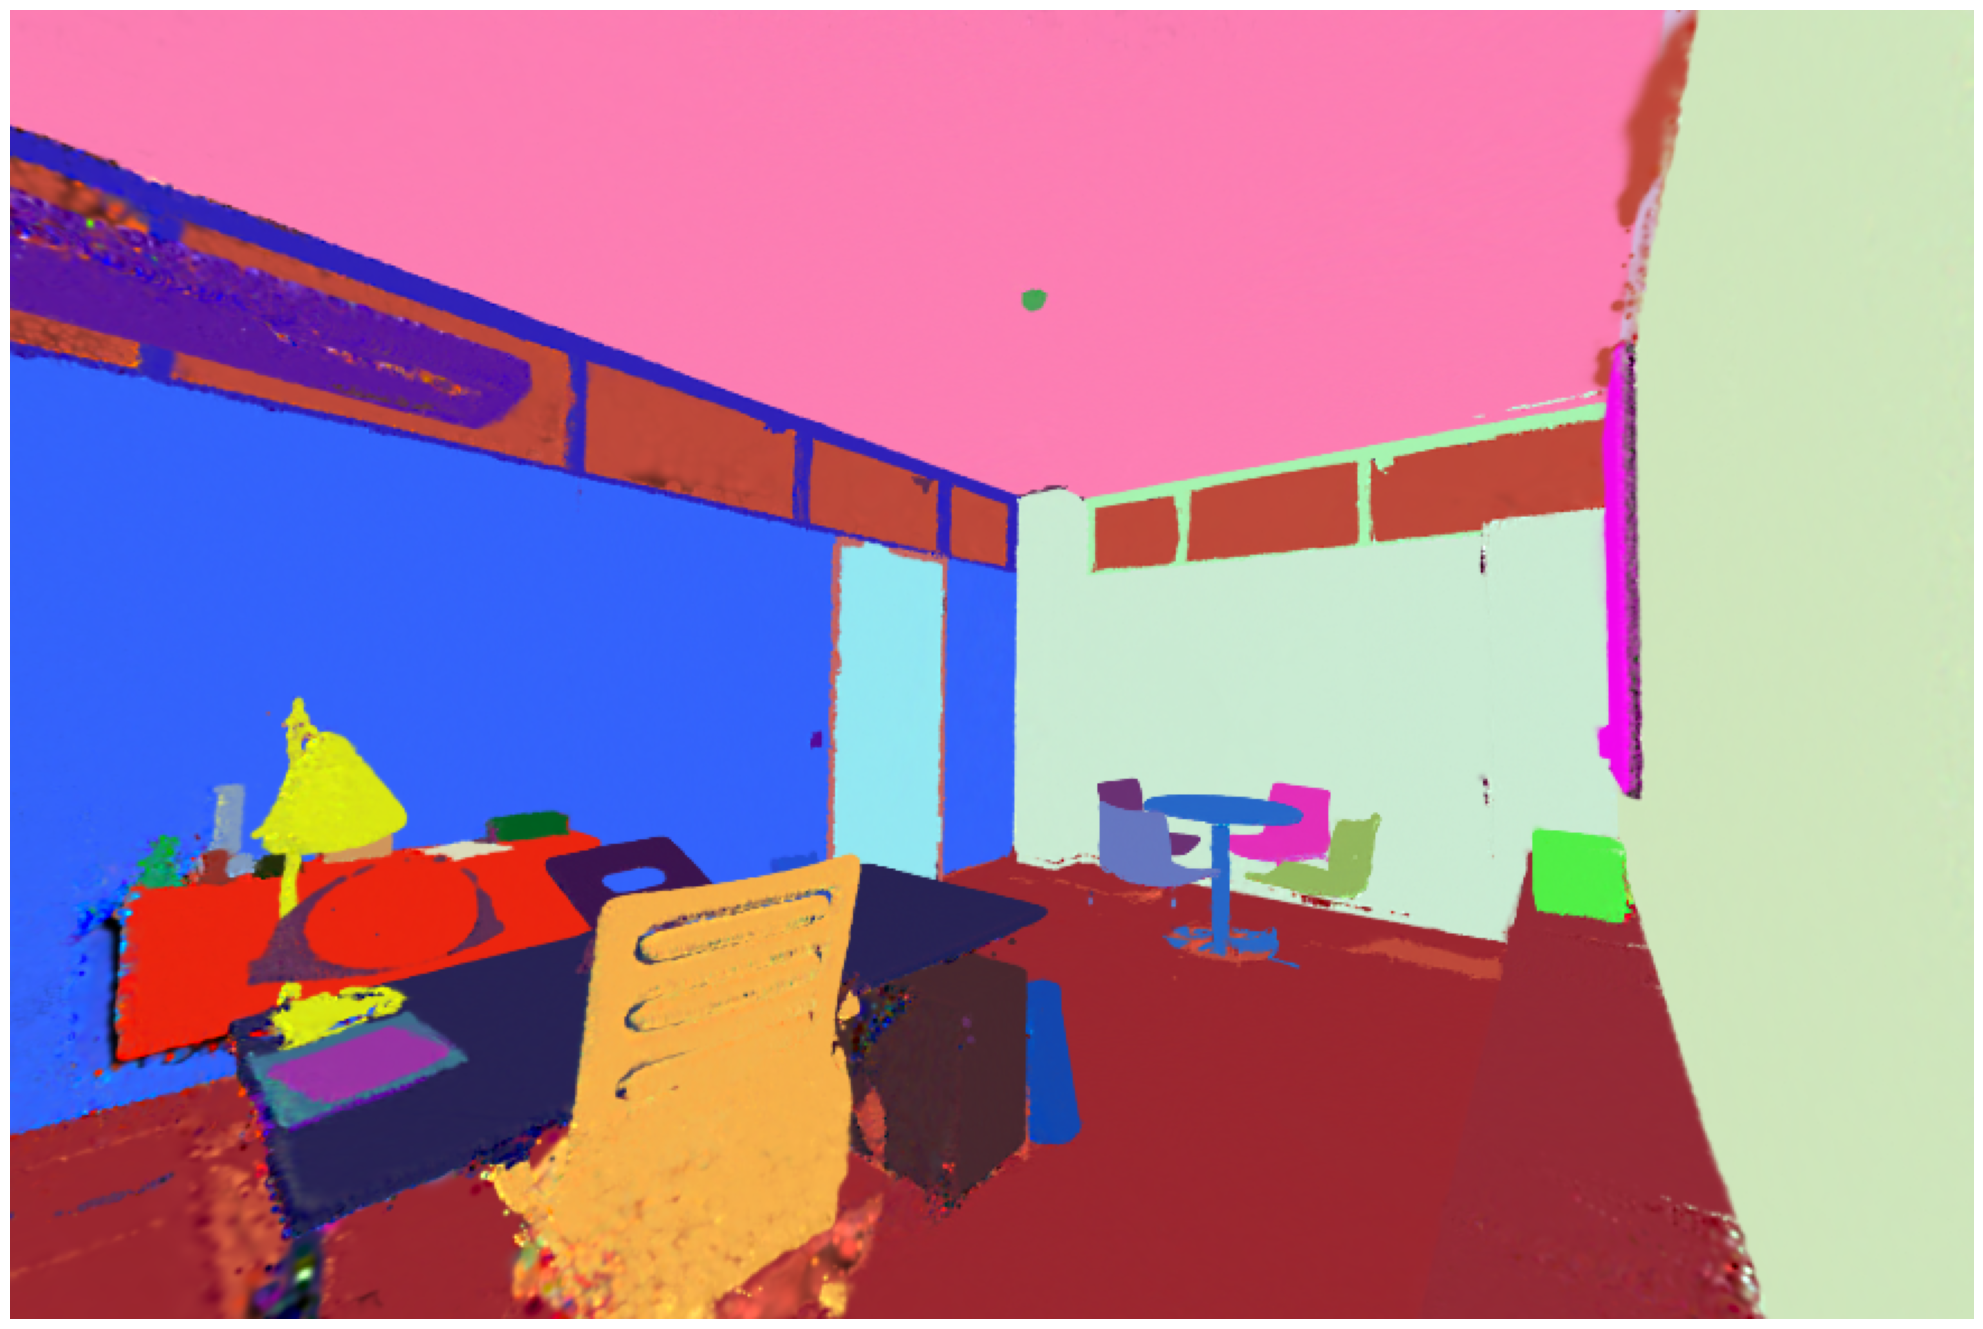

In [37]:
from utils.gs_helpers import semantics2rendervar

time_idx = -2
color, depth, intrinsics, pose, semantic_id, semantic_color = dataset[time_idx]
semantic_id = semantic_id.permute(2, 0, 1) # (H, W, 1) -> (1, H, W)
semantic_color = semantic_color.permute(2, 0, 1) / 255 # (H, W, C) -> (C, H, W)

gt_w2c = torch.linalg.inv(pose)
intrinsics = intrinsics[:3, :3]

# Process RGB-D Data
color = color.permute(2, 0, 1) / 255 # (H, W, C) -> (C, H, W)
depth = depth.permute(2, 0, 1) # (H, W, C) -> (C, H, W)

w2c = torch.linalg.inv(pose)

cam = setup_camera(color.shape[2], color.shape[1], intrinsics.cpu().numpy(),
                           w2c.detach().cpu().numpy(), device=device)
        
# Define current frame data
curr_data = {'cam': cam, 'im': color, 'depth': depth, 'id': time_idx, 'intrinsics': intrinsics, 'w2c': w2c}

curr_data['semantic_id'] = semantic_id
curr_data['semantic_color'] = semantic_color
semantic_rendervar = semantics2rendervar(params)
rastered_seg, _, _, = Renderer(raster_settings=curr_data['cam'])(**semantic_rendervar)

rendered_img = rastered_seg.detach().cpu().permute(1, 2, 0).numpy()

plt.figure(figsize=(30, 17))
plt.axis('off')
plt.imshow(rendered_img)
plt.savefig('./8b5caf3398_seg_270.png', bbox_inches='tight', pad_inches=0)

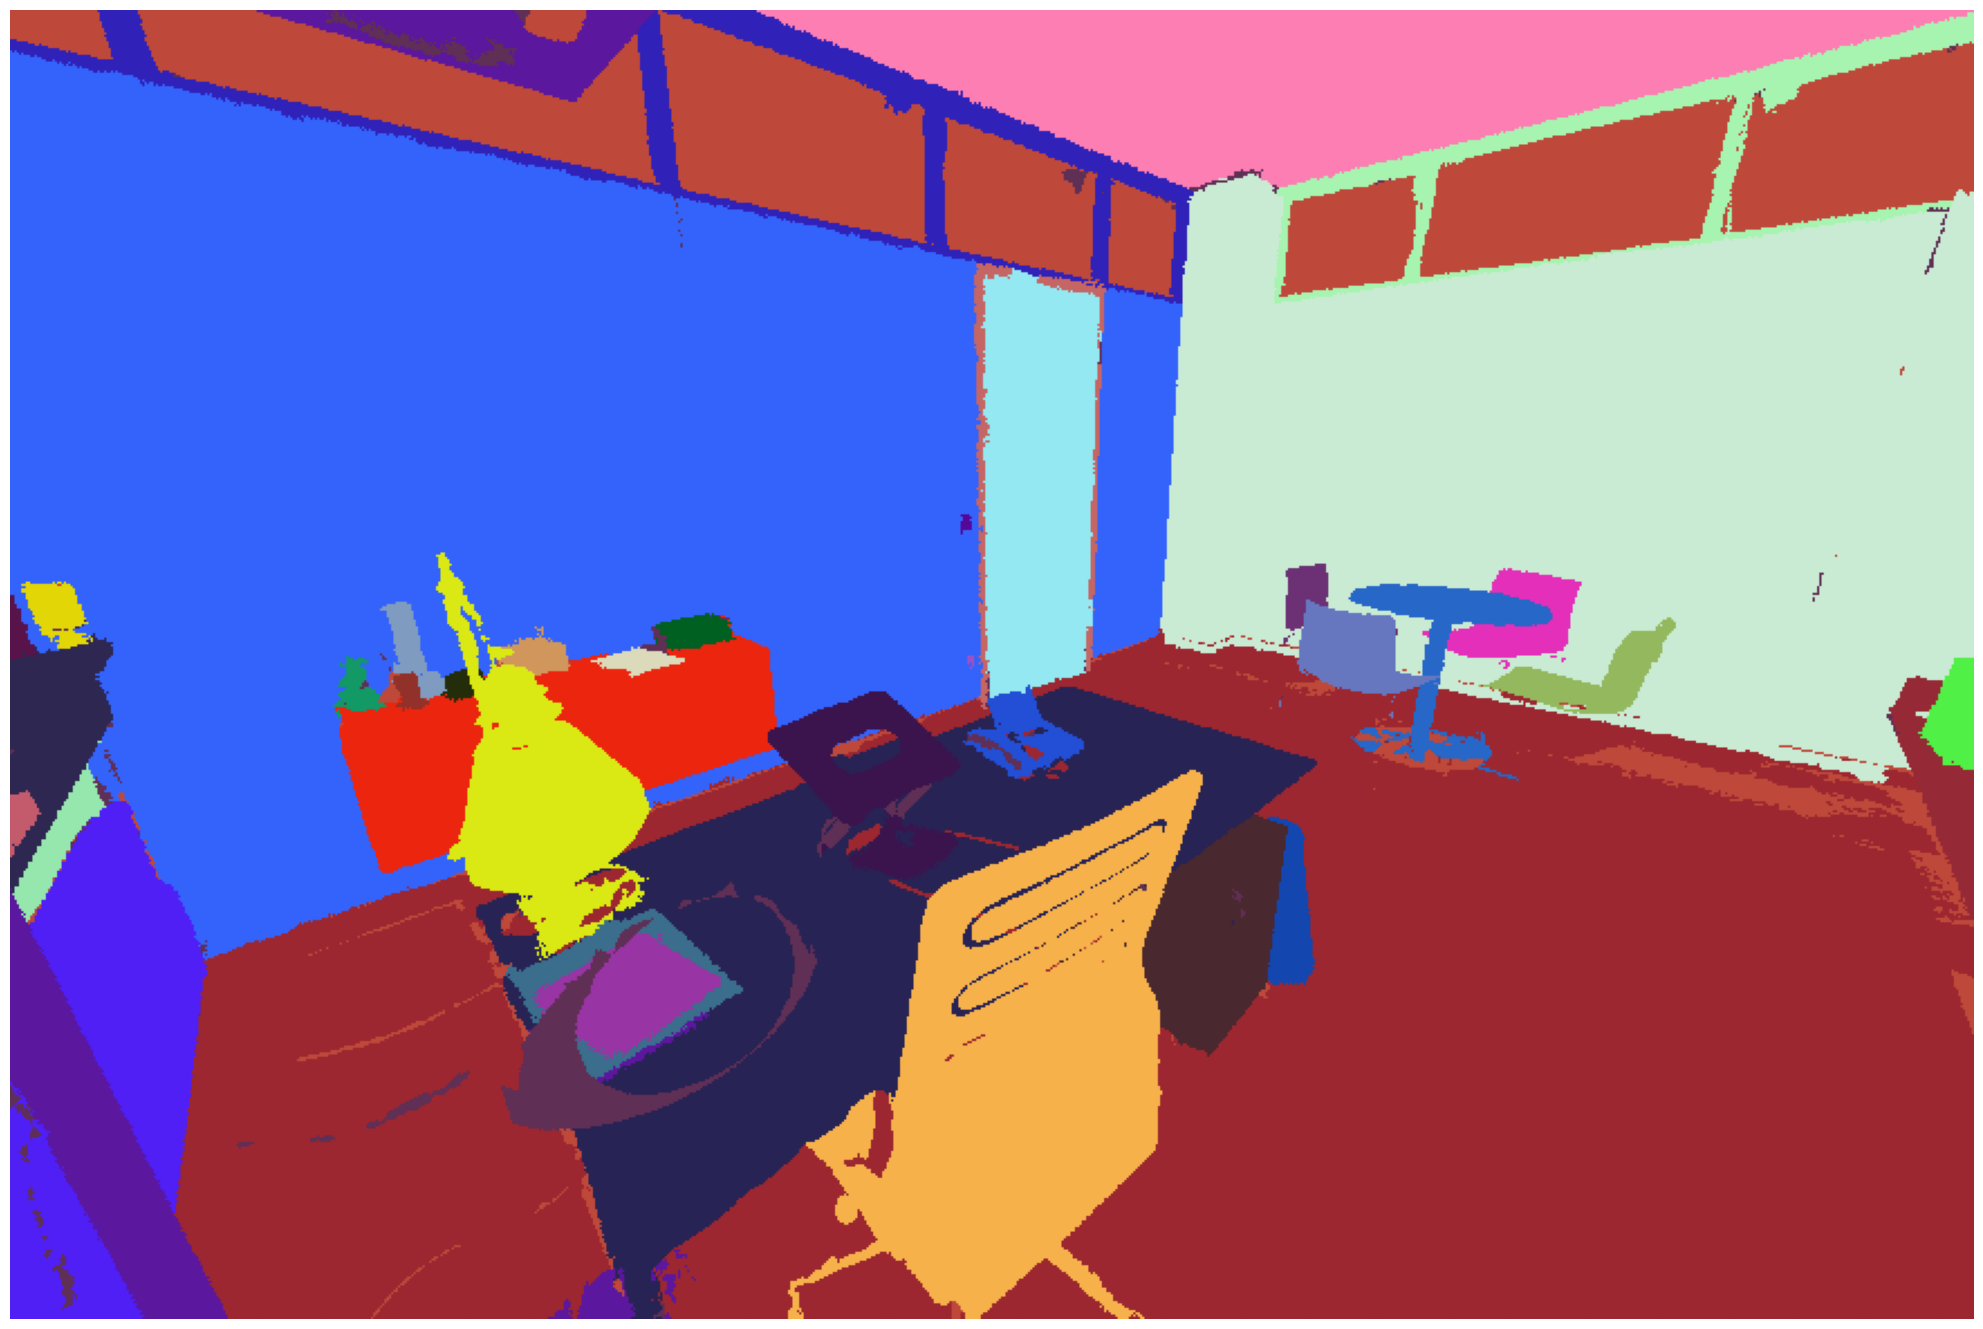

In [30]:
gt_seg = semantic_color
rastered_seg = recolor_semantic_img(rastered_seg, gt_seg)
miou = evaluate_miou(rastered_seg, gt_seg)

plt.figure(figsize=(30, 17))
plt.axis('off')
plt.imshow(semantic_color.cpu().permute(1, 2, 0))
plt.savefig('./8b5caf3398_gt_seg_269.png', bbox_inches='tight', pad_inches=0)

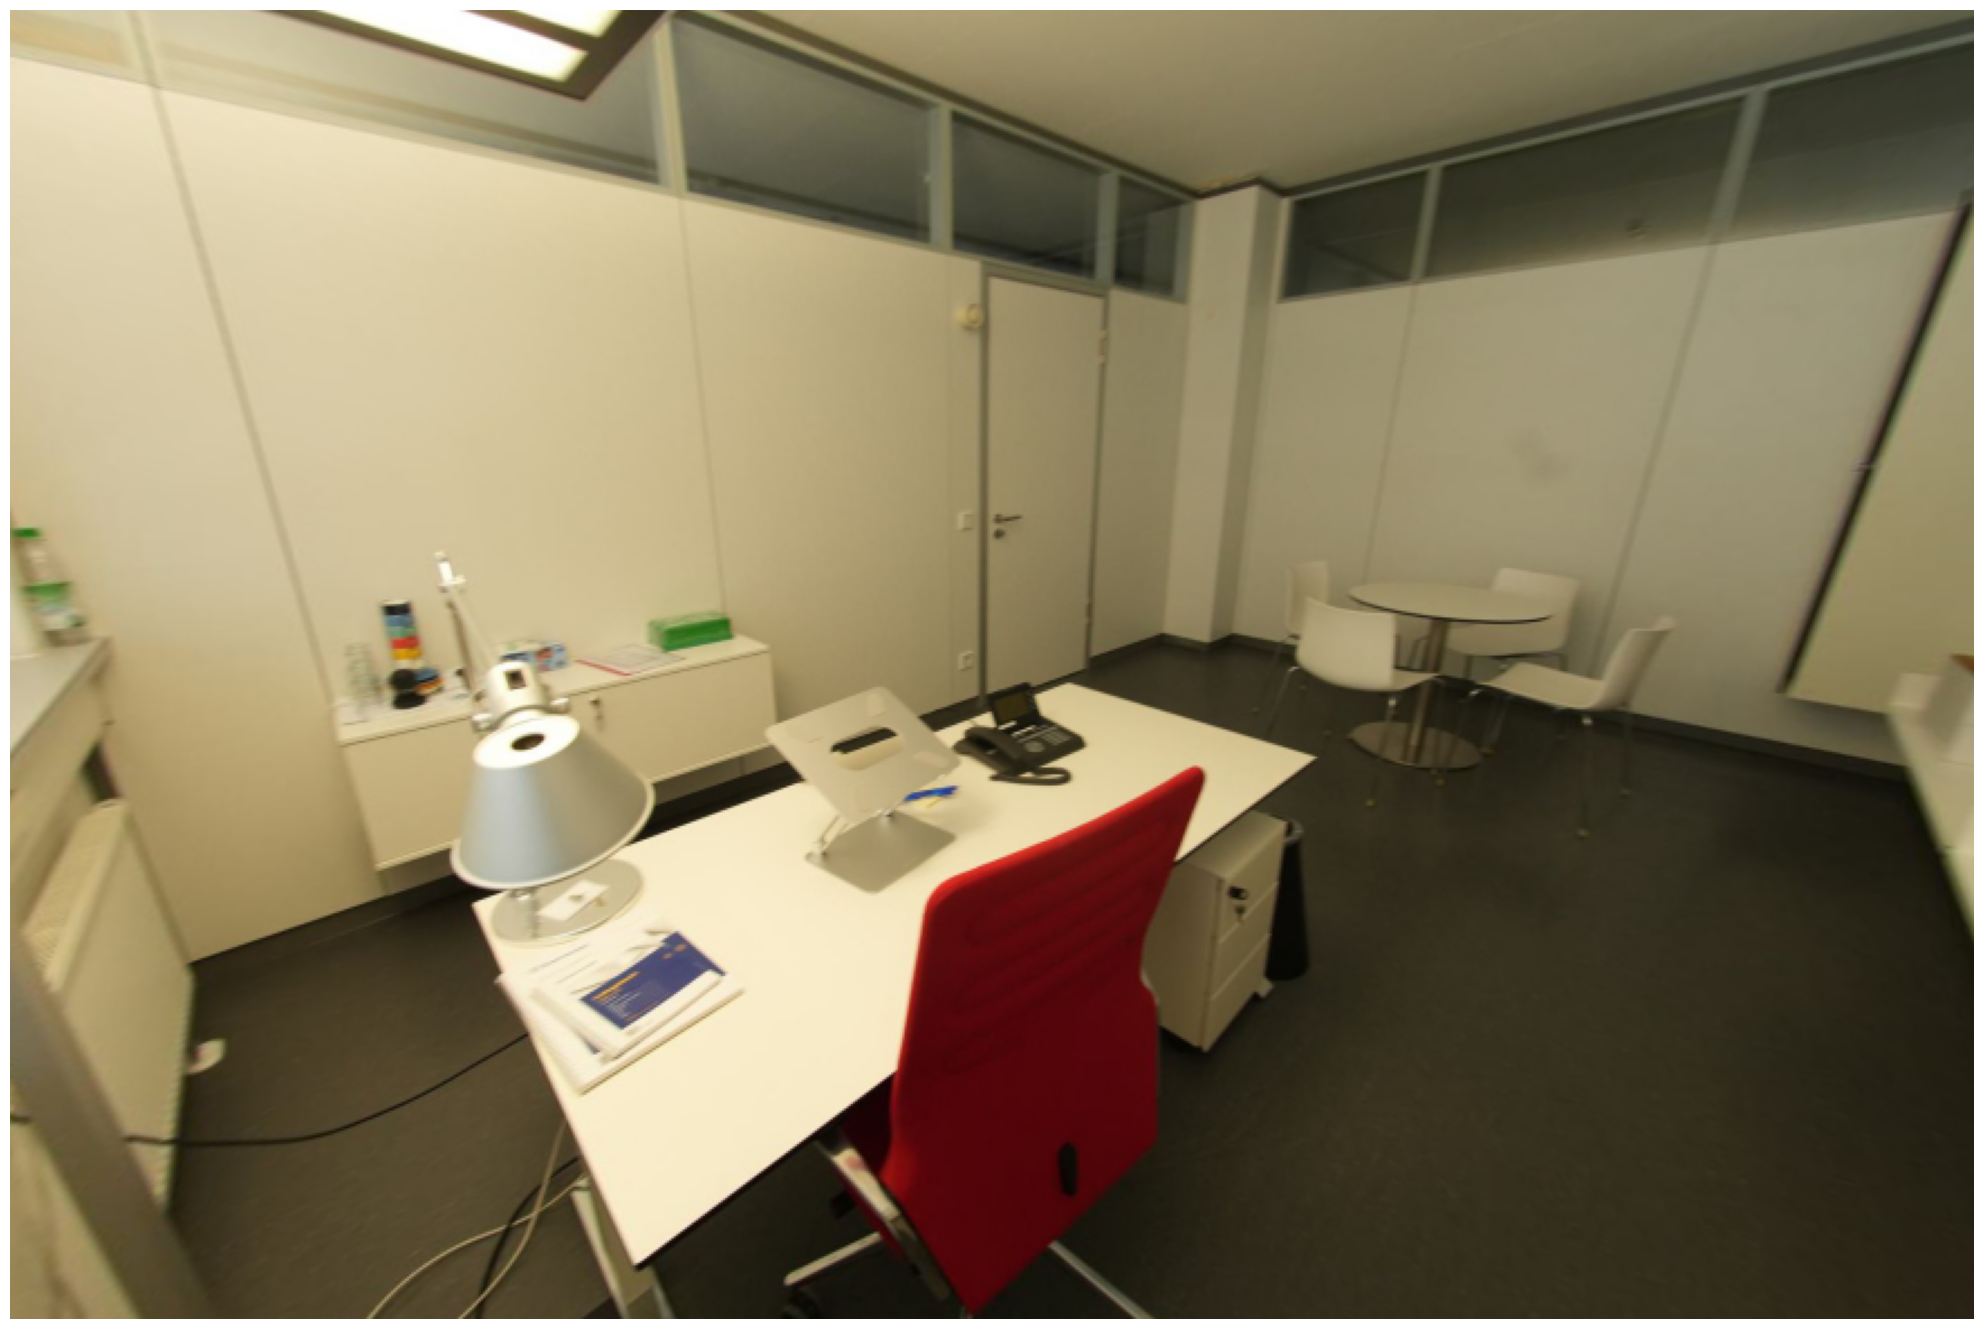

In [31]:
plt.figure(figsize=(30, 17))
plt.axis('off')
plt.imshow(color.cpu().permute(1, 2, 0))
plt.savefig('./8b5caf3398_gt_color_269.png', bbox_inches='tight', pad_inches=0)

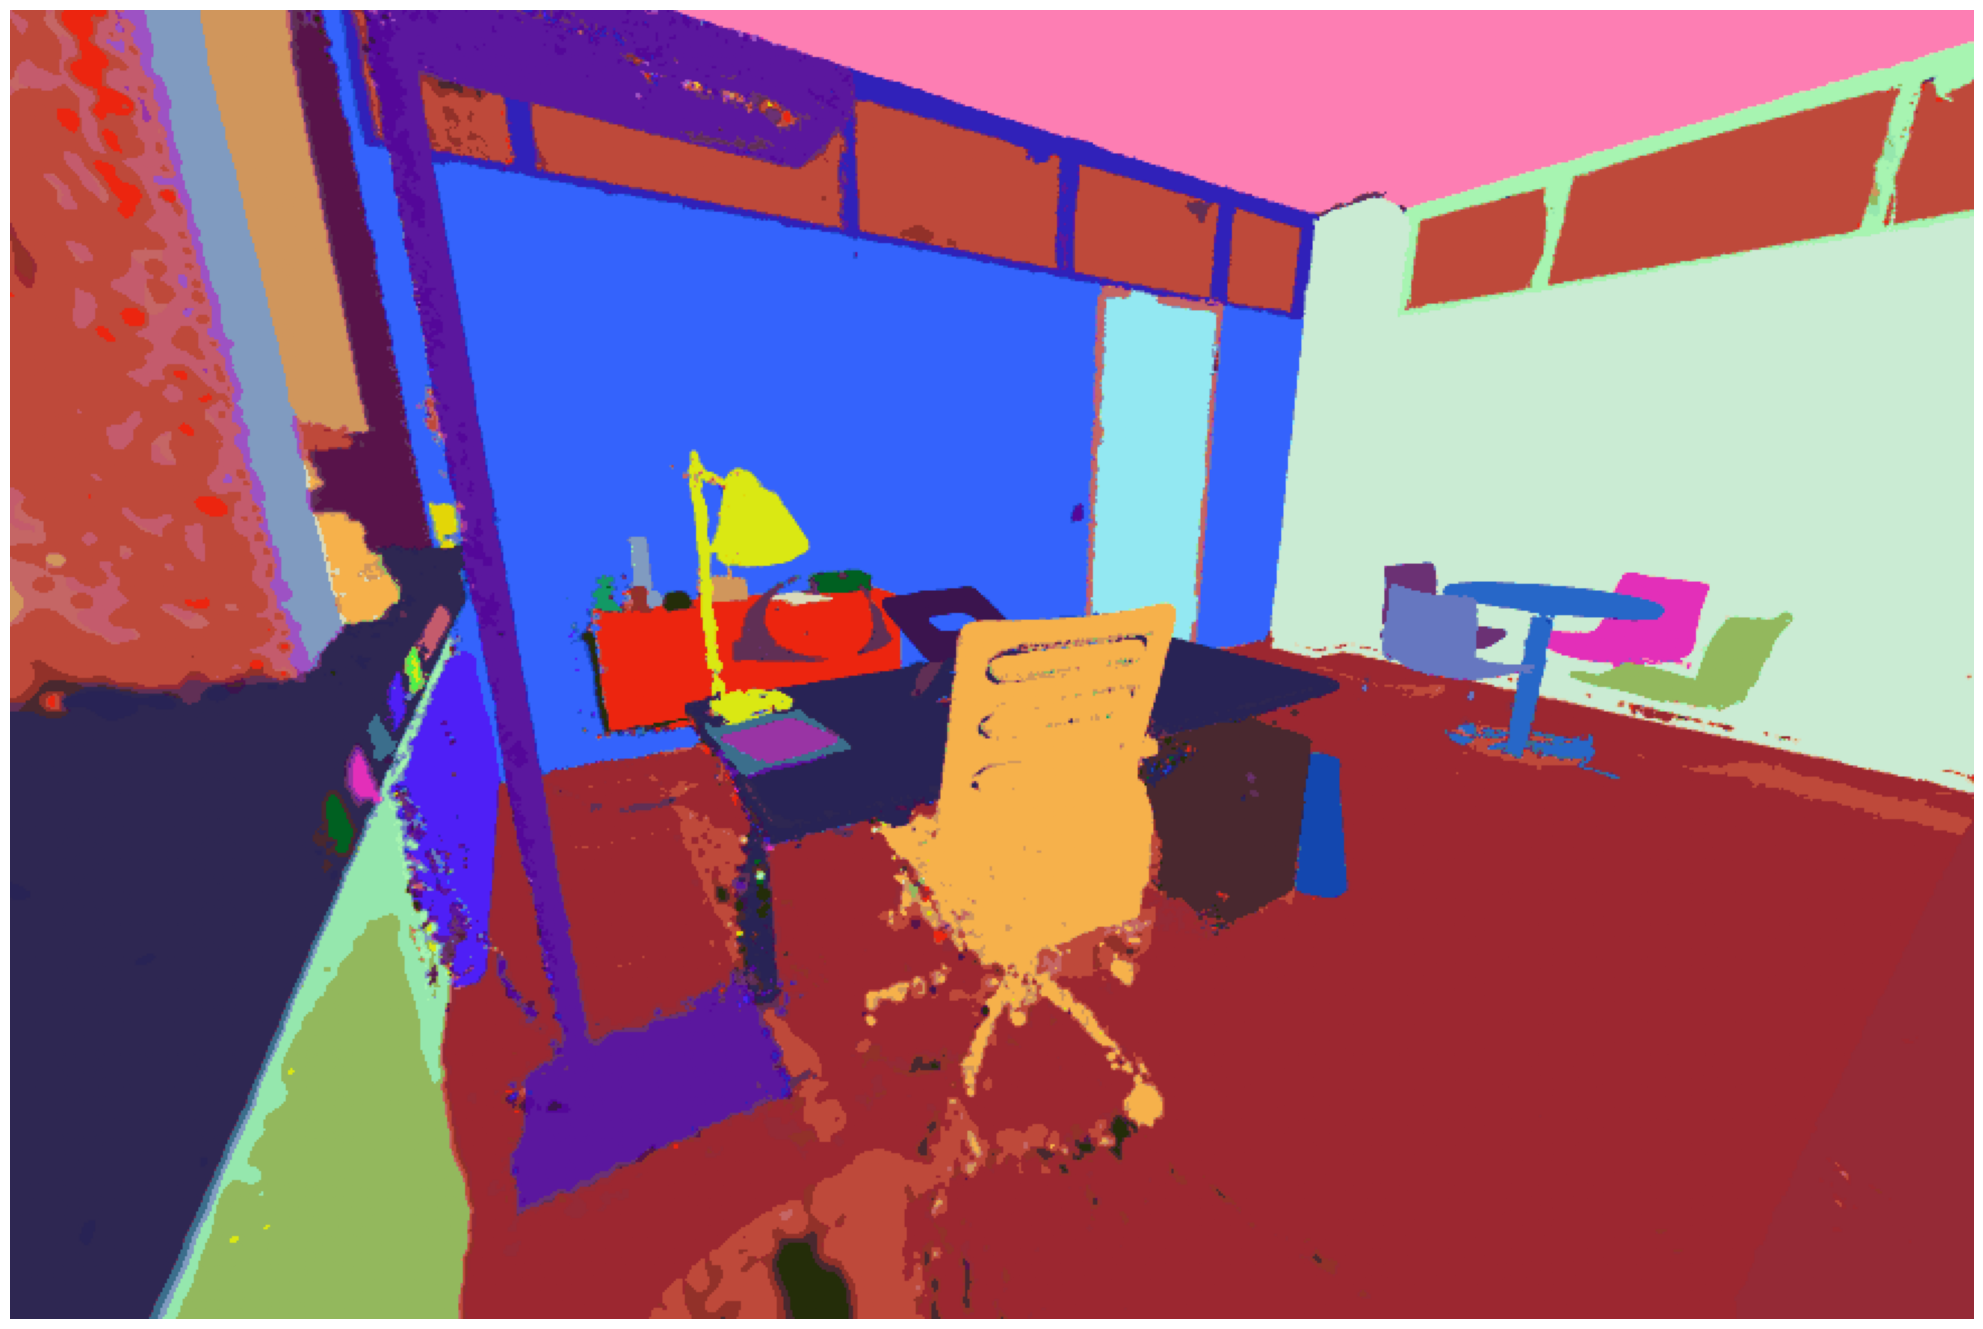

In [19]:
plt.figure(figsize=(30, 17))
plt.axis('off')
plt.imshow(rastered_seg.detach().cpu().permute(1, 2, 0))
plt.savefig('./8b5caf3398_seg_270.png', bbox_inches='tight', pad_inches=0)

### Test Replica Semantic Map

In [ ]:
import os
import argparse
import shutil
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from diff_gaussian_rasterization import GaussianRasterizer as Renderer
from utils.common_utils import seed_everything
from importlib.machinery import SourceFileLoader
from utils.recon_helpers import setup_camera
from PIL import Image
from tqdm import tqdm
from utils.gs_helpers import params2rendervar, semantics2rendervar

from datasets.gradslam_datasets import (
    load_dataset_config,
    ScannetPPDataset,
)

from utils.eval_helpers import recolor_semantic_img, evaluate_miou

# Create Results Directory and Copy Config
results_dir = './gen_figures/Replica/room0'
os.makedirs(results_dir, exist_ok=True)
os.makedirs(f'{results_dir}/frames', exist_ok=True)
os.makedirs(f'{results_dir}/semantics', exist_ok=True)


params = dict(np.load('./experiments/Replica_postopt/postopt_room0_0_semantic/params.npz', allow_pickle=True))
device = torch.device("cuda:0")
torch.cuda.set_device(0)

seed_everything(seed=0)

def get_dataset(config_dict, basedir, sequence, **kwargs):
    # return ScannetPPDataset(basedir, sequence, **kwargs)
    return ReplicaDataset(config_dict, basedir, sequence, **kwargs)


file_path = './configs/replica/slam.py'
experiment = SourceFileLoader(os.path.basename(file_path).replace('.py', ''), file_path).load_module()
config = experiment.config

# Set Experiment Seed
seed_everything(seed=config['seed'])

print("Loading Dataset ...")
dataset_config = config["data"]
if "gradslam_data_cfg" not in dataset_config:
    gradslam_data_cfg = {}
    gradslam_data_cfg["dataset_name"] = dataset_config["dataset_name"]
else:
    gradslam_data_cfg = load_dataset_config(dataset_config["gradslam_data_cfg"])
if "ignore_bad" not in dataset_config:
    dataset_config["ignore_bad"] = False
if "use_train_split" not in dataset_config:
    dataset_config["use_train_split"] = True
if "load_semantics" not in dataset_config:
    load_semantics = False
    num_semantic_classes = 0
else:
    load_semantics = dataset_config["load_semantics"]
    num_semantic_classes = dataset_config["num_semantic_classes"]
    semantic_color_all_frames_map = []
    semantic_id_all_frames_map = []

dataset = get_dataset(
    config_dict=gradslam_data_cfg,
    basedir=dataset_config["basedir"],
    sequence=os.path.basename(dataset_config["sequence"]),
    start=dataset_config["start"],
    end=dataset_config["end"],
    stride=dataset_config["stride"],
    desired_height=dataset_config["desired_image_height"],
    desired_width=dataset_config["desired_image_width"],
    device=device,
    relative_pose=True,
    ignore_bad=dataset_config["ignore_bad"],
    use_train_split=dataset_config["use_train_split"],
    load_semantics=load_semantics,
    num_semantic_classes=num_semantic_classes,
)

for k in ['intrinsics', 'w2c', 'org_width', 'org_height', 'gt_w2c_all_frames', 'keyframe_time_indices']:
    # for k in ['timestep','intrinsics', 'w2c', 'org_width', 'org_height', 'gt_w2c_all_frames']:
    if k in params.keys():
        params.pop(k)

params_opt_exclude = {"semantic_ids"}

print(params.keys())
for k in params.keys():
    if k in params_opt_exclude:
        params[k] = torch.tensor(params[k]).cuda()
    else:
        params[k] = torch.tensor(params[k]).cuda().float().requires_grad_(True)

if 'semantic_ids' in params.keys():
    if params['semantic_ids'].dim() == 1:
        params['semantic_ids'] = params['semantic_ids'].unsqueeze(1)

num_frames = len(dataset)


time_idx = 100

gt_w2c_list = []
color, depth, intrinsics, pose, semantic_id, semantic_color = dataset[time_idx]
semantic_id = semantic_id.permute(2, 0, 1) # (H, W, 1) -> (1, H, W)
semantic_color = semantic_color.permute(2, 0, 1) / 255 # (H, W, C) -> (C, H, W)
gt_w2c = torch.linalg.inv(pose)
gt_w2c_list.append(gt_w2c)
intrinsics = intrinsics[:3, :3]

# Process RGB-D Data
color = color.permute(2, 0, 1) / 255 # (H, W, C) -> (C, H, W)
depth = depth.permute(2, 0, 1) # (H, W, C) -> (C, H, W)

# Process Camera Parameters
w2c = torch.linalg.inv(pose)
if time_idx == 0:
    first_frame_w2c = w2c
# Setup Camera
cam = setup_camera(color.shape[2], color.shape[1], intrinsics.cpu().numpy(),
                    w2c.detach().cpu().numpy(), device=device)
        
# Define current frame data
curr_data = {'cam': cam, 'im': color, 'depth': depth, 'id': time_idx, 'intrinsics': intrinsics, 'w2c': w2c}

curr_data['semantic_id'] = semantic_id
curr_data['semantic_color'] = semantic_color
semantic_rendervar = semantics2rendervar(params)
rastered_seg, _, _, = Renderer(raster_settings=curr_data['cam'])(**semantic_rendervar)
gt_seg = semantic_color
rastered_seg = rastered_seg.detach().cpu().permute(1, 2, 0).numpy()

# Initialize Render Variables
rendervar = params2rendervar(params)
rastered_color, _, _, = Renderer(raster_settings=curr_data['cam'])(**rendervar)
rastered_color = rastered_color.detach().cpu().permute(1, 2, 0).numpy()

plt.imshow(rastered_color)

rastered_seg = rastered_seg * 255
rastered_seg = cv2.cvtColor(rastered_seg, cv2.COLOR_RGB2BGR)
cv2.imwrite(f'./gen_figures/Replica/room0/semantics/semantic{time_idx}.jpg', rastered_seg)

rastered_color = rastered_color * 255
rastered_color = cv2.cvtColor(rastered_color, cv2.COLOR_RGB2BGR)
cv2.imwrite(f'./gen_figures/Replica/room0/frames/color{time_idx}.jpg', rastered_color)

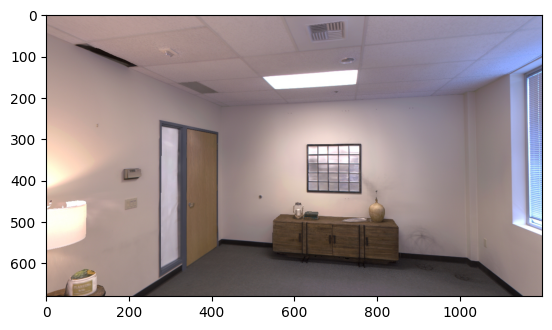

In [40]:
plt.imshow(color.detach().cpu().permute(1, 2, 0).numpy())